# Bot Si vs Bot No: una aproximación usando métricas disponibles.

Basados en el raw provisto por Yamila Abbas, se explora el concepto de si es viable separar bots vs personas, o bien cuentas con  ciertas caracteristicas across clusters de la investigación [dada](https://elgatoylacaja.com.ar/jugada-preparada/)

In [1]:
from __future__ import division

import pandas as pd
import numpy as np
import itertools
from sklearn import cross_validation
import xgboost
from sklearn import metrics
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
## Carguemos el corpus
corpus = pd.read_excel('/home/esteban/data/la_caja_del_gato/BD_MTIONS_CONICET201612.xlsx')
## Se cargó bien? 
corpus.head(5)

,Tweet ID,Text,Idioma,Source,User: ID,User:tweet count,User: followers,User: followings,User: time zone,Location,User: create date,Fecha
0,811536603155939328,RT @rukhasgunsalu: El CONICET tiene 25000 empl...,es,"<a href=""http://twitter.com/download/android"" ...",147424000,102964,1434,1605,NaN,ARGENTINA,2010-05-24 03:15:28,2016-12-21 08:39:38
1,811579120450732032,RT @rukhasgunsalu: El CONICET tiene 25000 empl...,es,"<a href=""http://twitter.com/download/android"" ...",500388742,8539,295,648,Atlantic Time (Canada),Lora´s Conch,2012-02-23 02:54:45,2016-12-21 11:28:35
2,811579285865713668,RT @rukhasgunsalu: El CONICET tiene 25000 empl...,es,"<a href=""http://twitter.com/download/iphone"" r...",481419614,368,33,96,Buenos Aires,NaN,2012-02-02 18:41:57,2016-12-21 11:29:14
3,811579342451077120,RT @rukhasgunsalu: El CONICET tiene 25000 empl...,es,"<a href=""http://twitter.com/download/iphone"" r...",387211339,1821,120,251,NaN,"Laboulaye, Cba",2011-10-08 17:15:33,2016-12-21 11:29:28
4,811579437342932992,RT @rukhasgunsalu: El CONICET tiene 25000 empl...,es,"<a href=""https://mobile.twitter.com"" rel=""nofo...",4020276615,17105,19317,884,NaN,NaN,2015-10-22 23:47:47,2016-12-21 11:29:50


In [27]:
# A ver cómo sale un ratio bayesiano de la distribución de siguiendo/me sigue
corpus['followers_followed_ratio'] =  (corpus['User: followings'] + 1) / (corpus['User: followers'] + 2)

In [28]:
corpus['followers_followed_ratio'].describe()

count    92130.000000
mean         1.804576
std          2.020427
min          0.000031
25%          0.782439
50%          1.238188
75%          2.196721
max        143.800000
Name: followers_followed_ratio, dtype: float64

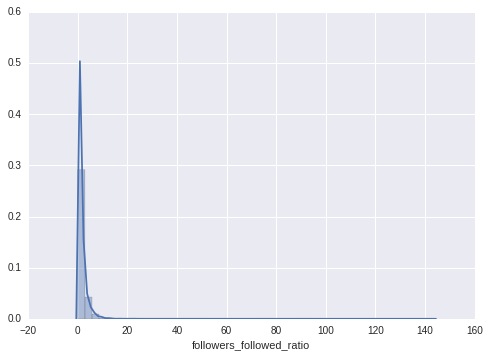

In [30]:
sns.distplot(corpus['followers_followed_ratio'])

La distribución sería menos normal que tu vieja en tanga. No se recomienda: hay que pegarle al API de twitter para sacar los retweets según [Tweets as impact indicators: Examining the implications of
automated “bot” accounts on Twitter ](https://pdfs.semanticscholar.org/c4db/d691ce21cea3af03d047b56580875cf1a8a1.pdf) a ver si se puede sacar algo útil.
Probemos al revés:

In [38]:
corpus['followers_followed_ratio'] =  (corpus['User: followers'] + 1) / (corpus['User: followings'] + 2)
corpus['followers_followed_ratio'].describe()

count    92130.000000
mean         8.326066
std        208.712748
min          0.005556
25%          0.449094
50%          0.802532
75%          1.272727
max      31981.945946
Name: followers_followed_ratio, dtype: float64

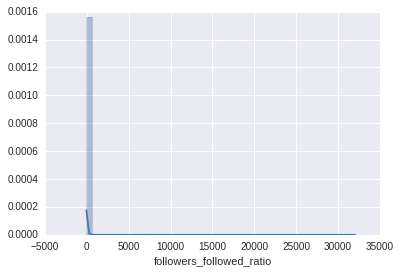

In [39]:
sns.distplot(corpus['followers_followed_ratio'])

Tampco. Esa métrica no estaría siendo estadísticamente significante para este corpus.
Veamos que surge de un análisis de obtener las métricas básicas del paper antes citado

In [58]:
# creemos una columna con los días desde que la cuenta se creó hasta el relevamiento
corpus['days'] =  corpus['Fecha '] - corpus['User: create date']
corpus['days'] = corpus['days'] / np.timedelta64(1, 'D')
corpus.loc[corpus['days'] < 0, 'days'] = 1 
corpus.days.describe()

count    92130.000000
mean      1527.452698
std        830.028944
min          0.021632
25%        796.187199
50%       1621.760046
75%       2284.134566
max       3602.685116
Name: days, dtype: float64

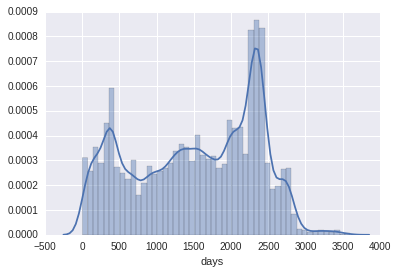

In [59]:
sns.distplot(corpus.days)

AHORA SI. Como decíamos en en análsis preliminar, la cantidad de días de creación de la fecha es un buen indicador.
Saquemos ahora la cantidad de twits por día

## Twits por Día

In [115]:
corpus['twits_por_día'] = corpus['User:tweet count'] / corpus['days']

In [116]:
corpus.twits_por_día.describe()

count    92130.000000
mean        30.410198
std         64.482774
min          0.001287
25%          3.337275
50%         10.733209
75%         32.703094
max       2015.595658
Name: twits_por_día, dtype: float64

## Usuarios por Día

In [119]:
corpus['creation_date'] = corpus['User: create date'].dt.date
users_per_day = corpus.groupby(corpus['creation_date'])['Idioma'].count()
users_per_day.describe()

count    3121.000000
mean       29.519385
std        29.484824
min         1.000000
25%        12.000000
50%        23.000000
75%        39.000000
max       617.000000
Name: Idioma, dtype: float64

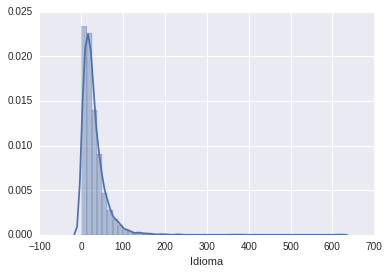

In [128]:
sns.distplot(users_per_day)

Esta parece ser una distribución un poco más usable. Utilizaremos el criterio de que los outliers deberían estar fuera del rango de 4 std. Es decir, se deberían haber creado más de 240 cuentas ese día, con esta base de datos, para poder asumir que ese día es un outlier.

## Hipótesis

Asumiendo que existan operadores de algún tipo, deberíamos inferir que las cuentas se crearon cerca de algún evento significativo. Supongamos, para esta hipótesis, que las cuentas que operan fueron creadas:

- El día de la muerte de Néstor Kirchner (2010-10-27)
- El día de la asunciónd de Mauricio Macri (2015-12-10)

Especial atención merece el período desde el 5 de diciembre, que es cuando se desencadenó el conflicto.

Para asumir un P significante, entendemos que estas fechas deberían estar dentro del rango de outliers.

## Demostración

In [135]:
users_per_day[users_per_day > 120]

creation_date
2010-05-07    153
2010-05-13    121
2010-05-18    159
2010-05-19    192
2010-05-21    124
2010-05-24    138
2010-06-05    141
2010-06-08    165
2010-06-09    138
2010-06-10    170
2010-07-08    126
2010-07-10    231
2010-07-12    170
2010-07-15    164
2010-08-01    132
2010-08-03    122
2010-08-09    135
2010-08-18    155
2010-08-20    124
2010-09-03    200
2010-09-04    168
2010-09-05    137
2010-09-12    617
2010-09-30    146
2010-10-13    141
2010-10-27    364
2010-10-28    136
2011-02-14    136
2011-07-26    138
2013-04-15    122
2013-11-21    382
2014-12-29    155
2015-08-13    141
2015-11-11    206
2015-11-15    235
2015-11-16    151
2015-12-14    136
2015-12-15    149
2016-07-15    186
2016-10-09    187
Name: Idioma, dtype: int64

## Conclussions & Findings

Efectivamente, para este corpus en particular, las fechas alrededor del 27 de octubre del 2010 hay una cantidad significativa de nuevas cuentas de twitter. Sin embargo, es sólo la mitad de la hipótesis: No se observa ese pico en la fecha de asunción de Mauricio Macri, sino hasta cinco días después. Tampoco se observan, como dato anecdótico, cuando se ganó el ballotage. Ni nuevas cuentas en un ritmo acelerado para diciembre del 2016, cuando se desató el conflicto.

Preliminarmente, entendemos que el resultado es inconcluyente.
Como pasos posteriores, se recomienda un sampleo de las cuentas creadas alrededor del pico detectado (27, 28 de octubre del 2010) para investigar el tipo de contenido que comarten, así como el rango de fechas del debate presidencial (2015-11-11 al 16).



## ADDENDA

Este es un análisis preliminar realizado en base a la edad de las cuentas en días, en un espíritu similar a la anterior. Se descarta ya que la distribución absoluta de cuentas por edad no tiene una distribución analizable con el rango de datos que tenemos.

In [130]:
MUERE_NESTOR = 2246
ASUME_MACRI = 392
DELTA = 5
print("{} creados en la muerte de nestor, {} en la asuncion de Macri".format(
        corpus[corpus['days'].between(MUERE_NESTOR, MUERE_NESTOR+DELTA)]['User: ID'].count(), 
        corpus[corpus['days'].between(ASUME_MACRI-DELTA*2, ASUME_MACRI+DELTA*2)]['User: ID'].count()))


487 creados en la muerte de nestor, 1247 en la asuncion de Macri


In [131]:
SIGMA = 2 * corpus.days.std()
PUNTO_MEDIO = corpus.iloc[0]['Fecha '] - pd.to_timedelta(corpus.days.mean() , unit='d')
print("{} Mínimo, {} Máximo".format(PUNTO_MEDIO - pd.to_timedelta(SIGMA, unit='d'), PUNTO_MEDIO + pd.to_timedelta(SIGMA, unit='d')))

2008-03-30 20:24:23.283200 Mínimo, 2017-05-02 23:11:06.502400 Máximo
